# 1. Introduction

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
from statsmodels.robust.scale import huber
import glob
import os
import pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
sns.set(style='white', context='notebook', palette='deep')

### The code is set to sort .txt file into a 0 "nagative" or 1 "positive" based on file name "Human" this can be changed to recognize any word you put into the file name to identify the positive and negative classes but all the files must be located at this path

In [43]:
def process_text_files(folder_path):
    data = []
    label_array = []
    header = None
    first_file = True
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                new_row = pd.read_csv(file, sep='\t', header=None, skiprows=13)
                new_row = new_row.iloc[1:, :] 
                if first_file:  # Read header from the first file
                    header = new_row[0]
                    first_file = False
                new_row=new_row[1] 
                if 'Human' in file_name:
                    label_array.append(1)
                else:
                    label_array.append(0)
                row_float = []
                row_float = [float(value) for value in new_row]  
                data.append(row_float)
                
    label_array = np.array(label_array).reshape(-1, 1)  # Reshape to column vector
    data = np.array(data)  # Convert data to NumPy array
    return data, label_array, header

folder_path = 'C:\\Users\\heather\\Desktop\\Stool Data'

file_data, label_array, header = process_text_files(folder_path)
print(header.shape, file_data.shape, label_array.shape)
# Add the label column to the data array
data_with_labels = np.hstack((label_array, file_data))
# Generate column names for the DataFrame
columns = np.append('label',header)

df = pd.DataFrame(data_with_labels, dtype=float, columns=columns)

(2047,) (13, 2047) (13, 1)


In [44]:
df.head()

,label,339.706,340.089,340.472,340.854,341.237,341.619,342.002,342.384,342.766,...,1025.175,1025.46,1025.745,1026.03,1026.315,1026.6,1026.885,1027.17,1027.455,1027.74
0,0.0,-16.67,87.5,-75.0,175.00,-50.00,30.0,0.00,0.0,50.00,...,37.50,18.75,13.64,4.55,16.67,16.67,16.67,50.00,-50.00,55.00
1,0.0,-47.06,2600.0,2600.0,-22.86,-47.06,800.0,-52.63,800.0,58.82,...,44.76,32.17,42.99,31.46,31.46,51.69,51.69,90.14,71.91,64.79
2,0.0,411.76,-5200.0,-5200.0,148.57,200.00,-1600.0,10.53,2000.0,-117.65,...,-13.99,-26.57,-52.34,-83.15,-62.92,-42.70,-62.92,-53.52,-42.70,-28.17
3,0.0,-11.76,2000.0,200.0,-5.71,-11.76,200.0,-84.21,-1600.0,94.12,...,36.36,23.78,31.78,17.98,17.98,38.20,38.20,47.89,58.43,47.89
4,0.0,411.76,-5200.0,-5200.0,148.57,200.00,-1600.0,10.53,2000.0,-117.65,...,-1.40,-13.99,-35.51,-62.92,-42.70,-22.47,-22.47,-53.52,-22.47,-28.17


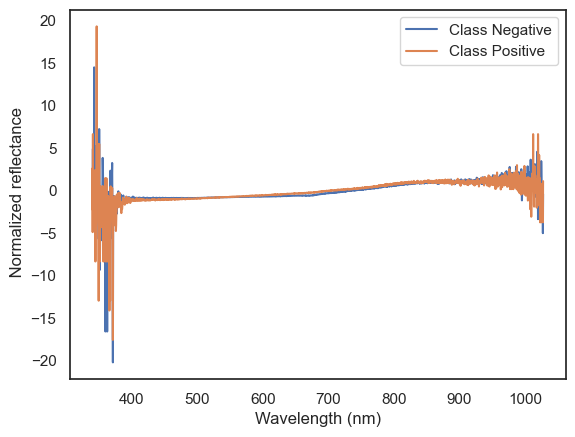

In [48]:
def norm_func(x):
    x=pd.DataFrame(x)
    for row_index in range(len(x)):
        Hmean, Hstd = huber(x.iloc[row_index, :])
        HCentered = x.iloc[row_index, :] - Hmean
        Hnorm = HCentered / Hstd
        x.iloc[row_index, :] = Hnorm
    x.to_numpy()
    return x

wavelengths=df.columns.values[1:].astype(float)

X=df.loc[:, df.columns != 'label'] # selects all but the class label
X= norm_func(X)

Y=df.loc[:, df.columns == 'label'] 

indices_Y_equals_1 = np.where(Y['label'] == 1)[0]
indices_Y_equals_0=np.where(Y['label'] == 0)[0]

# Plotting based on Y=1
plt.plot(wavelengths,pd.DataFrame(X.iloc[indices_Y_equals_1[0]]), label='Class Negative')
plt.plot(wavelengths, pd.DataFrame(X.iloc[indices_Y_equals_0[0]]), label='Class Positive')
plt.xlabel('Wavelength (nm)')
plt.ylabel(' Normalized reflectance')
plt.legend()
plt.show()


# 2. Data preparation
## 2.1 Split

In [49]:
# Spliting into test and training sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.3, random_state = 0)

In [50]:
# classification ratio if about 1:1 we dont need to adjust if not 50% 50% we need to rebalance the minority class
y_train.value_counts()
# y_test.value_counts()

label
1.0      5
0.0      4
Name: count, dtype: int64

## 2.2 Check for null and missing values

In [51]:
# Check the data
X_train.isnull().any().describe()

count      2047
unique        1
top       False
freq       2047
dtype: object

In [52]:
# top:False freq:1, indicates no null values which means we are okay to proceed
y_test.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Label encoding

In [54]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# Set the random seed
random_seed = 2
# Y_train = to_categorical(y_train, num_classes = 2)
pd.DataFrame(y_train).value_counts()

label
1.0      5
0.0      4
Name: count, dtype: int64

# 3. CNN
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [76]:
# Set the CNN model 

# , input_shape=(2047, 1)
from keras.layers import Input

# Define input shape
input_shape = (2047,1)

# Create Sequential model
model = Sequential()

# Add Input layer with specified input shape
model.add(Input(shape=input_shape))

# Add Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the feature maps
model.add(Flatten())
model.add(Dropout(0.25))

# Add fully connected layers
model.add(Dense(128, activation='linear'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

## 3.2 Set the optimizer and annealer



In [77]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<img src="http://img1.imagilive.com/0717/learningrates.jpg"> </img>

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [78]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [79]:
epochs = 20 # More epochs increases accuracy
batch_size = 86

In [80]:
# Convert data to numpy arrays if they are not already
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify data shape and labels
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9, 2047) (9, 1)
(4, 2047) (4, 1)


## 3.3 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

In [83]:
np.random.seed(2)

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
validation_data = (X_test, y_test), verbose = 2)

Epoch 1/20
1/1 - 1s - 1s/step - accuracy: 0.4444 - loss: 1.7298 - val_accuracy: 0.5000 - val_loss: 0.9852
Epoch 2/20
1/1 - 0s - 141ms/step - accuracy: 0.6667 - loss: 0.9253 - val_accuracy: 1.0000 - val_loss: 1.5307e-16
Epoch 3/20
1/1 - 0s - 136ms/step - accuracy: 0.8889 - loss: 3.1789 - val_accuracy: 1.0000 - val_loss: 1.1304e-23
Epoch 4/20
1/1 - 0s - 178ms/step - accuracy: 0.8889 - loss: 4.5288 - val_accuracy: 1.0000 - val_loss: 2.3611e-25
Epoch 5/20
1/1 - 0s - 136ms/step - accuracy: 0.8889 - loss: 4.3424 - val_accuracy: 1.0000 - val_loss: 1.6284e-23
Epoch 6/20
1/1 - 0s - 139ms/step - accuracy: 0.8889 - loss: 3.3627 - val_accuracy: 1.0000 - val_loss: 2.9396e-19
Epoch 7/20
1/1 - 0s - 138ms/step - accuracy: 0.8889 - loss: 1.5473 - val_accuracy: 1.0000 - val_loss: 2.4389e-13
Epoch 8/20
1/1 - 0s - 145ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 2.9270e-08
Epoch 9/20
1/1 - 0s - 137ms/step - accuracy: 1.0000 - loss: 1.2769e-07 - val_accuracy: 1.0000 - val_los

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [84]:
# Fit the model
pred = model.predict(X_test)
pred[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([1.], dtype=float32)

# 4. Evaluate the model
## 4.1 Training and validation curves

Text(0, 0.5, 'Loss value')

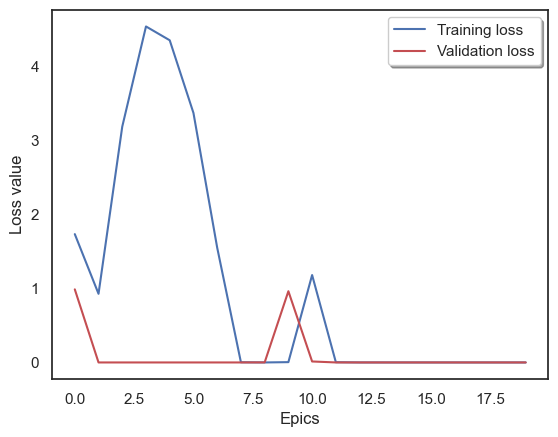

In [85]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax.legend(loc='best', shadow=True)
plt.xlabel('Epics')
plt.ylabel('Loss value')


## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted probabilities: [[1.]
 [1.]
 [0.]
 [1.]]
Predicted classes: [[1]
 [1]
 [0]
 [1]]


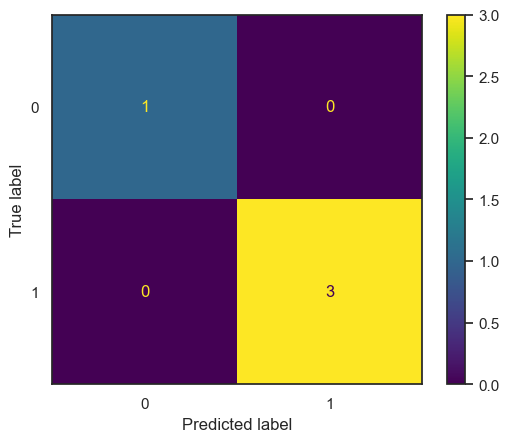

In [88]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
# Applying threshold
threshold = 0.5
y_class = (y_pred> threshold).astype(int)

print("Predicted probabilities:", y_pred)
print("Predicted classes:", y_class)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_class) 
# plot the confusion matrix

# Displays the confusion matrix
cm_display=ConfusionMatrixDisplay(confusion_mtx).plot()